In [1]:
%reset -sf

import sys
sys.path.insert(0, '..')
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os
import glob
import shutil

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
print(tf.__version__)
print(tf.config.list_physical_devices(), end='\n\n')

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 128

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [3]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 1024
EPOCHS = 1024
LEARNING_RATE = 1e-4

w_lead shape: (2928862, 9)
               E            px            py             pz             m  \
0  114813.382812 -16190.328125  63319.132812   50221.468750  79927.953125   
1  450737.750000  70425.804688   3821.072266  438394.468750  77462.359375   
2  102566.046875 -10254.437500  45208.792969   79655.101562  45009.675781   

             pt       eta       phi         y  
0  65356.249165  0.707823  1.821127  0.469034  
1  70529.387911  2.526646  0.054204  2.138567  
2  46357.183371  1.310057  1.793846  1.036803  
                  E            px            py            pz             m  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   2.283278e+05 -1.788823e+01  1.700620e+01  2.688194e+02  7.062466e+04   
std    2.440128e+05  3.510948e+04  3.504798e+04  3.222953e+05  1.877761e+04   
min    1.596886e+04 -1.474598e+06 -7.555793e+05 -4.386726e+06  2.000148e+03   
25%    9.528028e+04 -1.782399e+04 -1.778516e+04 -1.062248e+05  7.283715e+04  

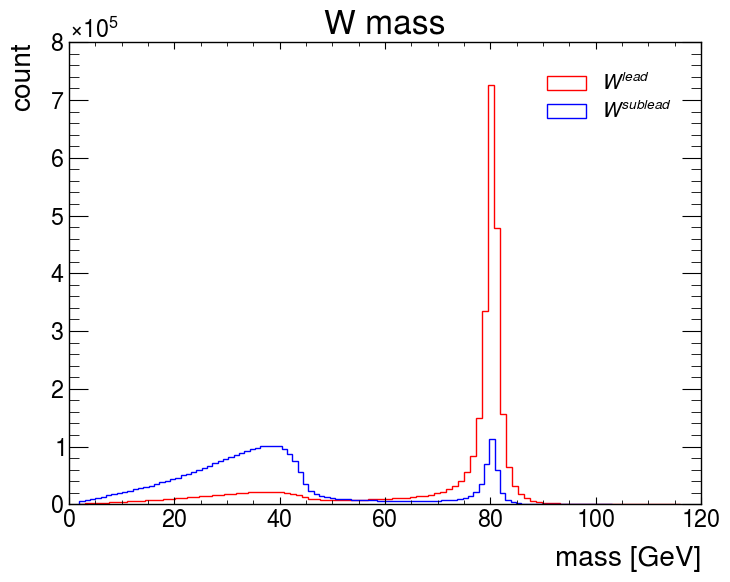

int_kin shape: (1378510, 1)
           py
7   -3.569852
9  -31.827225
10  21.866621
                 py
count  1.378510e+06
mean   2.473961e-02
std    3.704611e+01
min   -7.555793e+02
25%   -1.789962e+01
50%    3.047990e-02
75%    1.794664e+01
max    7.608027e+02
<class 'numpy.ndarray'>


In [4]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
print("w_lead shape:", w_lead.shape)
print(w_lead.head(3))
print(w_lead.describe())

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin = w_lead[["py"]][PRE_CUT] / GEV
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print(int_kin.describe())
# int_kin = int_kin.to_numpy() # convert to numpy array
# STDSCALAR_INT = StandardScaler()
# int_kin = STDSCALAR_INT.fit_transform(int_kin)
# ROBUST_INT = RobustScaler()
# int_kin = ROBUST_INT.fit_transform(int_kin)
MINMAX_INT = MinMaxScaler()
int_kin = MINMAX_INT.fit_transform(int_kin) 
print(type(int_kin))

In [5]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["E", "px", "py", "pz"]]
sublead_lep = data.SubLep[["E", "px", "py", "pz"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
STDSCALAR_OBS = StandardScaler()
obs_kin = STDSCALAR_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1378510, 10)


             E         px         py          pz          E         px  \
7    43.361348  42.407754  -4.632000    7.767462  19.500895  -4.561588   
9   164.814766  34.397141   2.031300 -161.172625  70.592648  29.001777   
10   90.238664 -23.868604  32.986602   80.530680  47.669113 -26.605045   

           py         pz         px         py  
7   18.924410  -1.154271  96.335650  47.095450  
9    1.896990 -64.332027 -26.992604 -70.883859  
10 -17.256748  35.590859  44.222846 -15.383637  
                  E            px            py            pz             E  \
count  1.378510e+06  1.378510e+06  1.378510e+06  1.378510e+06  1.378510e+06   
mean   1.228232e+02 -2.283103e-02  2.369144e-02  1.919805e-01  7.518447e+01   
std    1.474662e+02  3.340791e+01  3.335215e+01  1.860197e+02  9.723482e+01   
min    2.200140e+01 -6.775440e+02 -5.162718e+02 -2.858096e+03  1.500272e+01   
25%    4.539499e+01 -2.507789e+01 -2.505726e+01 -5.382219e+01  2.680265e+01   
50%    7.137519e+01 -2.476472e-02

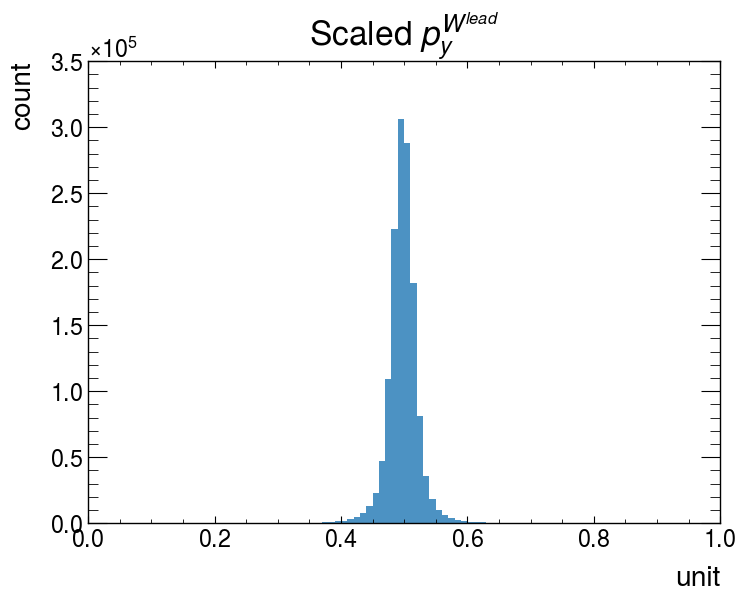

In [6]:
plt.hist(int_kin, bins=100, alpha=0.8)
plt.title("Scaled" + r" $p_{y}^{W^{lead}}$")
plt.xlabel("unit")
plt.ylabel("count")
plt.show()
plt.close()

In [7]:
# # Create a normalizer layer

# layer_obs = tf.keras.layers.Normalization(axis=-1)
# layer_obs.adapt(obs_kin)

In [8]:
# # Check observing variables

# obs_check = layer_obs(obs_kin).numpy()

# fig, axs = plt.subplots(3, 4, figsize=(8, 5), dpi=120, sharex=True, sharey=True)

# titles = [
#     r"$E^{lead}$",
#     r"$p_x^{lead}$",
#     r"$p_y^{lead}$",
#     r"$p_z^{lead}$",
#     r"$E^{sublead}$",
#     r"$p_x^{sublead}$",
#     r"$p_y^{sublead}$",
#     r"$p_z^{sublead}$",
#     r"$p_x^{miss}$",
#     r"$p_y^{miss}$",
# ]
# for i in range(3):
#     for j in range(4):
#         if 4 * i + j < obs_check.shape[1]:
#             axs[i, j].hist(obs_check[:, 4 * i + j], bins=100, alpha=0.8, density=True)
#             axs[i, j].set_title(titles[4 * i + j], fontsize=10)
#             if i == 2:
#                 axs[i, j].set_xlabel("unit", fontsize=8)
#             if j == 0:
#                 axs[i, j].set_ylabel("Normalized", fontsize=8)
#             axs[i, j].tick_params(axis="both", which="both", labelsize=8, length=2)
#             axs[i, j].set_xlim([-5, 5])
#             axs[i, j].set_ylim([0, 2])
#         else:
#             axs[i, j].axis("off")

# fig.suptitle('Scaled observing variables', fontsize=12) 
# plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.6,
    test_size=0.4,
    random_state=SEED,
    # shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (827106, 10);
Validing data shape: (275702, 10);
Testing data shape: (275702, 10).
Y (Observed)
Training data shape: (827106, 1);
Validing data shape: (275702, 1);
Testing data shape: (275702, 1).


In [10]:
percentile_25 = np.percentile(int_kin, 25)
median = np.median(int_kin)
percentile_75 = np.percentile(int_kin, 75)
print(
    f"""25th percentile: {percentile_25:.2f};
median         : {median:.2f};
75th percentile: {percentile_75:.2f}."""
)

25th percentile: 0.49;
median         : 0.50;
75th percentile: 0.51.


In [11]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)
    # x = layer_obs(inputs)
    # Hidden tf.keras.layers
    # x = tf.keras.layers.Dense(units=128, activation="elu", kernel_initializer="normal")(
    #     x
    # )
    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    # x = tf.keras.layers.Dropout(rate=0.1)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=2, activation="elu")(x)
    # x = tf.keras.layers.Dense(units=2, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(rate=0.1)(x)
    # x = tf.keras.layers.Dense(units=1024, activation="elu")(x)
    # x = tf.keras.layers.Dense(units=1024, activation="elu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(rate=0.1)(x)
    # x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    # x = tf.keras.layers.Dense(units=4, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="sigmoid")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [12]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 16)                272   

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.01)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/1024
808/808 - 6s - loss: 0.0031 - val_loss: 1.7331e-04 - lr: 1.0000e-04 - 6s/epoch - 7ms/step
Epoch 2/1024
808/808 - 3s - loss: 4.2596e-04 - val_loss: 1.1759e-04 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 3/1024
808/808 - 3s - loss: 2.2507e-04 - val_loss: 1.0003e-04 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 4/1024
808/808 - 3s - loss: 1.5361e-04 - val_loss: 9.0315e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 5/1024
808/808 - 3s - loss: 1.2139e-04 - val_loss: 8.4335e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 6/1024
808/808 - 3s - loss: 1.0450e-04 - val_loss: 8.1030e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 7/1024
808/808 - 3s - loss: 9.5074e-05 - val_loss: 7.8799e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 8/1024
808/808 - 3s - loss: 8.9520e-05 - val_loss: 7.7709e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 9/1024
808/808 - 3s - loss: 8.6346e-05 - val_loss: 7.6625e-05 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 10/1024
808/808 - 3s - loss: 8.3998

In [14]:
# Make a directory
dir_name = "./w_lead_result/"
name = "dnn_w_lead_py_scaled"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
else:
    os.makedirs(dir_name)

# save model
model.save(dir_name + name + ".h5", save_format="h5", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

   1/8616 [..............................] - ETA: 13:39

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8616/8616 [==============================] - 10s 1ms/step


In [15]:
print(
    f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}"
)

Truth mean: 0.498, std: 0.024, min: 0.089, max: 0.876


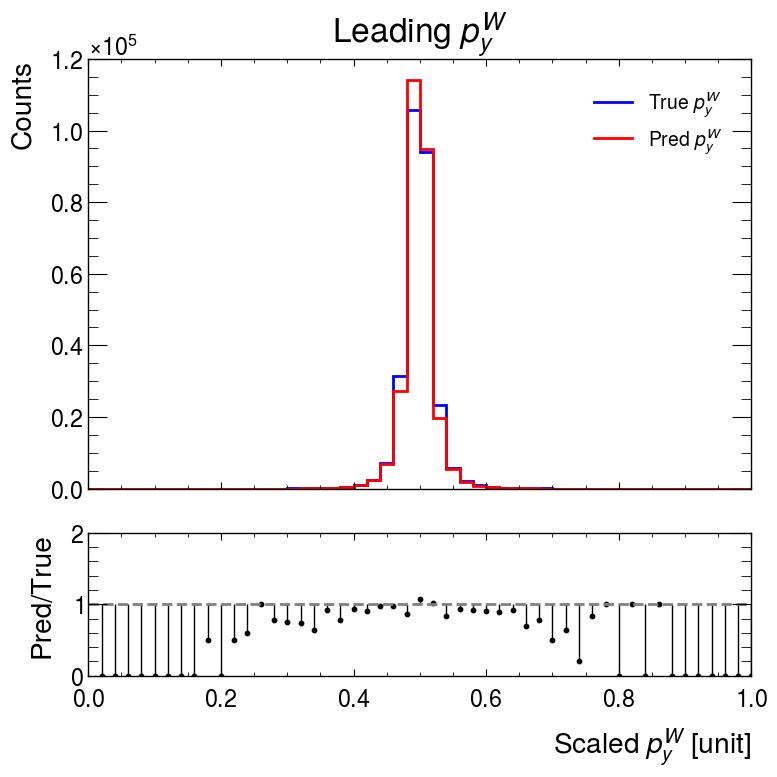

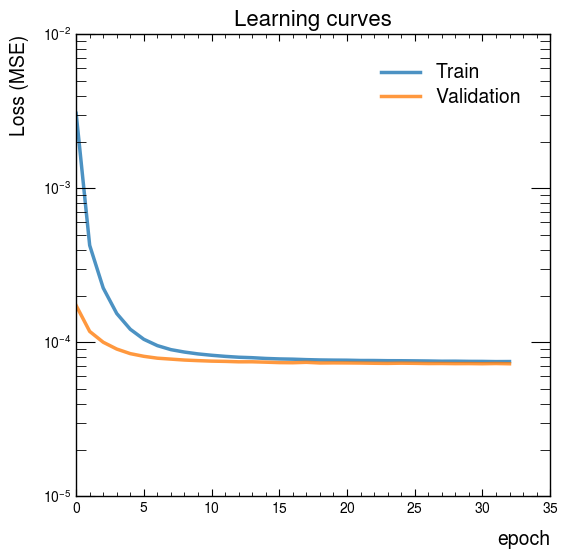

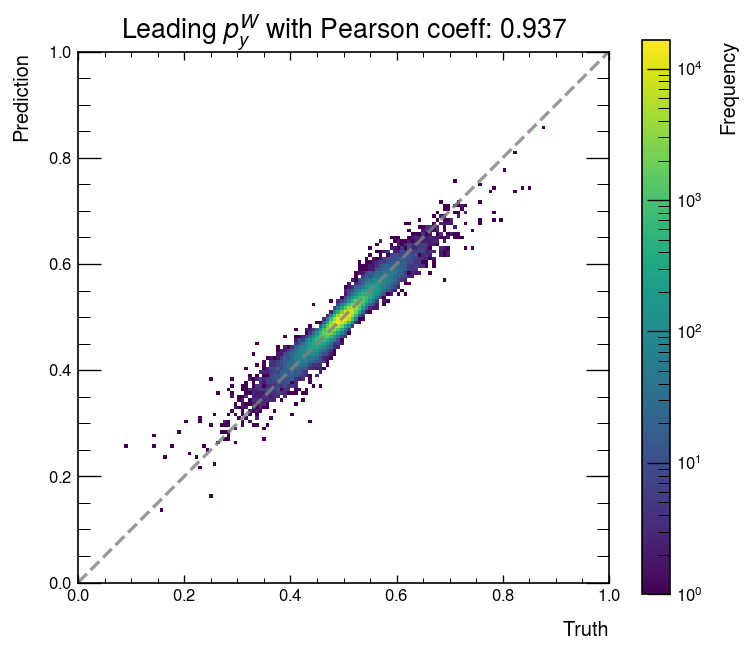

In [22]:
range = [0, 1]

plot.hist(
    data=[sig_truth[:, 0], sig_pred[:, 0]],
    label=r"$p_{y}^{W}$",
    title="Leading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    range=range,
)

plot.plot_loss_history(history, logx=False, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Leading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)

In [17]:
sig_truth_inv = MINMAX_INT.inverse_transform(sig_truth).flatten()
sig_pred_inv = MINMAX_INT.inverse_transform(sig_pred).flatten()

In [18]:
# Make a directory
dir_name = "./w_lead_result/"
name = "dnn_w_lead_py"

# # If the directory exists
# if os.path.exists(dir_name):
#     test_files = glob.glob(dir_name + "*" + name + "*")
#     if test_files:
#         for file in test_files:
#             os.remove(file)
# else:
#     os.makedirs(dir_name)
    
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=sig_pred_inv, test_y=sig_truth_inv)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

In [19]:
print(
    f"Truth mean: {np.mean(sig_truth_inv):.3f}, std: {np.std(sig_truth_inv):.3f}, min: {np.min(sig_truth_inv):.3f}, max: {np.max(sig_truth_inv):.3f}"
)

Truth mean: 0.007, std: 37.097, min: -620.586, max: 573.168


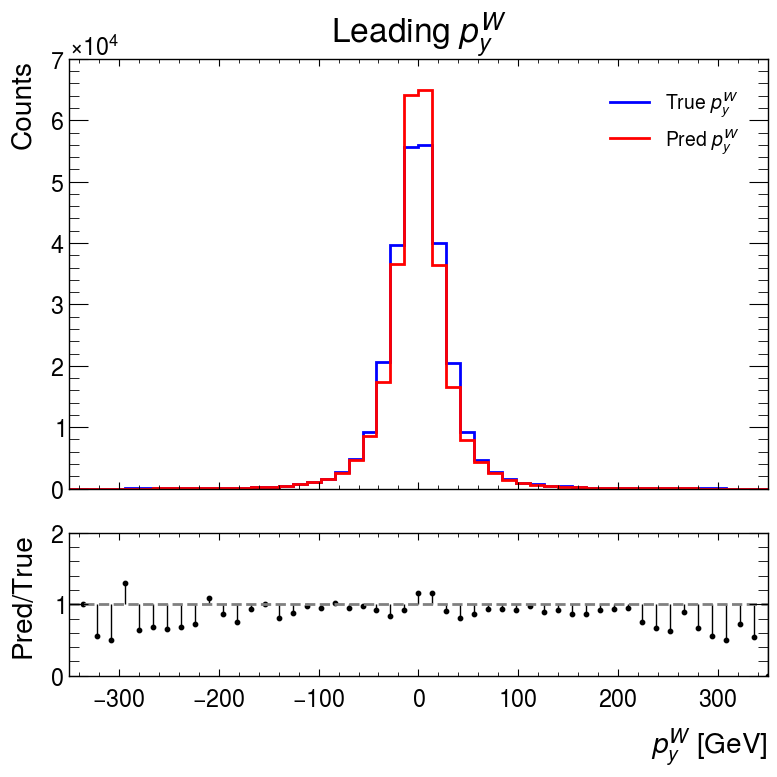

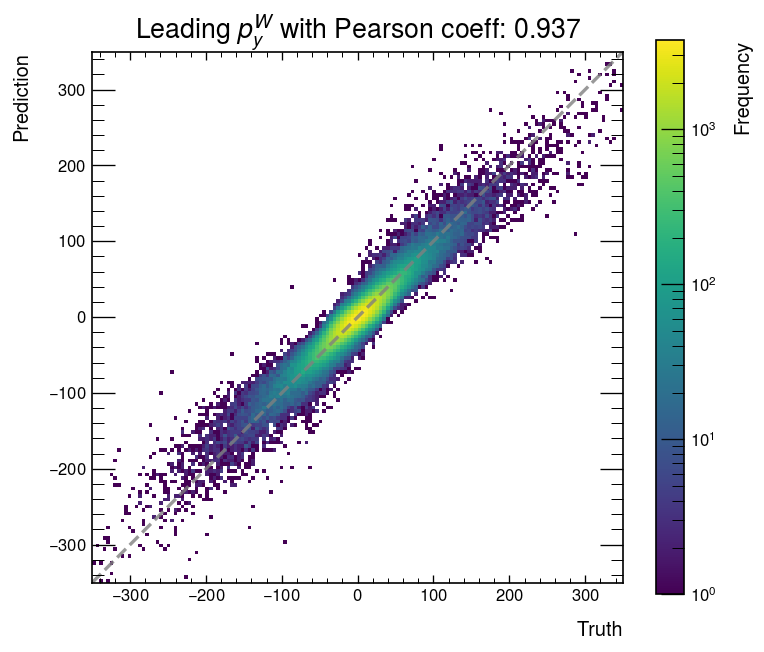

In [21]:
range = [-350, 350]

plot.hist(
    data=[sig_truth_inv, sig_pred_inv],
    label=r"$p_{y}^{W}$",
    title="Leading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv, sig_pred_inv)):.3f}",
    range=range,
    unit = "[GeV]"
)

plot.plot_2d_histogram(
    sig_truth_inv,
    sig_pred_inv,
    r"Leading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv, sig_pred_inv)[0]:.3f}",
    range=range,
)